In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, classification_report, confusion_matrix
from zipfile import ZipFile

In [2]:
#Providing the path dataset
data_path="images.zip"


In [3]:
#Extracting Data from zip
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print("Dataset has been Extracted")

Dataset has been Extracted


In [4]:
#Set path
df = "pillQC/images"

In [5]:
#Set image size
image_size = (256,256)
batch_size = 32
#Pre-processing our image (Downscaling the image)
datagen=ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

In [6]:
#Image augmentation for increasing the size of dataset
import Augmentor
import os
import shutil

In [7]:
num_new_images_per_class = 150  #Defining how many new images generated PER class

In [8]:
# List of class names
class_names = ["chip", "dirt", "normal"]

def create_pipeline(class_path):
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10,max_right_rotation=10)
    p.flip_left_right(probability=0.5)
    p.zoom_random(probability=0.5,percentage_area=0.6)
    p.random_contrast(probability=0.5, min_factor=0.7,max_factor=1.2)
    p.random_brightness(probability=0.5, min_factor=0.7,max_factor=1.2)
    p.shear(probability=0.5, max_shear_left=10,max_shear_right=10)
    p.random_color(probability=0.5, min_factor=0.7,max_factor=1.2)
    p.sample(num_new_images_per_class)
    return p

In [9]:
# Applying pipeline and generate images
for class_name in class_names:
    class_path = os.path.join("pillQC/images", class_name)
    pipeline = create_pipeline(class_path)
    print(f"Augmenting class: {class_name}")
    pipeline.sample(num_new_images_per_class)

Initialised with 43 image(s) found.
Output directory set to pillQC/images\chip\output.

Processing <PIL.Image.Image image mode=RGB size=225x225 at 0x156E88E5850>: 100%|██████████| 150/150 [00:01<00:00, 129.00 Samples/s]


Augmenting class: chip


Processing <PIL.Image.Image image mode=RGB size=225x225 at 0x156F04D3850>: 100%|██████████| 150/150 [00:00<00:00, 188.49 Samples/s]


Initialised with 138 image(s) found.
Output directory set to pillQC/images\dirt\output.

Processing <PIL.Image.Image image mode=RGB size=225x225 at 0x156E186DB10>: 100%|██████████| 150/150 [00:00<00:00, 239.35 Samples/s]


Augmenting class: dirt


Processing <PIL.Image.Image image mode=RGB size=225x225 at 0x156CB3AEE50>: 100%|██████████| 150/150 [00:00<00:00, 189.36 Samples/s]                  


Initialised with 149 image(s) found.
Output directory set to pillQC/images\normal\output.

Processing <PIL.Image.Image image mode=RGB size=225x225 at 0x156EDA43510>: 100%|██████████| 150/150 [00:00<00:00, 204.79 Samples/s]                


Augmenting class: normal


Processing <PIL.Image.Image image mode=RGB size=225x225 at 0x156F048AFD0>: 100%|██████████| 150/150 [00:00<00:00, 204.36 Samples/s]


In [10]:
# Moving generated images back to class folders and removing output folders
def move_augmented_images(class_path):
    output_dir = os.path.join(class_path, "output")
    for file_name in os.listdir(output_dir):
        if file_name.endswith(".jpg"):
            shutil.move(os.path.join(output_dir, file_name), os.path.join(class_path, file_name))
    os.rmdir(output_dir)

In [11]:
for class_name in class_names:
    class_path = os.path.join("pillQC/images", class_name)
    move_augmented_images(class_path)
    print(f"Moved augmented images for: {class_name}")

Moved augmented images for: chip
Moved augmented images for: dirt
Moved augmented images for: normal


In [12]:
# Load training data
train_data = datagen.flow_from_directory(
    df,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)


Found 986 images belonging to 3 classes.


In [13]:
# Load validation data
val_data = datagen.flow_from_directory(
    df,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 244 images belonging to 3 classes.


In [14]:
# Class names
class_names = list(train_data.class_indices.keys())
print("Classes found:", class_names)

Classes found: ['chip', 'dirt', 'normal']


In [15]:
# Gather counts
train_counts = train_data.classes
val_counts = val_data.classes

# Count per class
train_dist = pd.Series(train_counts).value_counts().sort_index()
val_dist = pd.Series(val_counts).value_counts().sort_index()

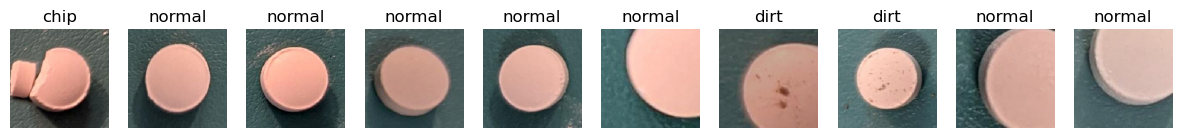

In [16]:
# Get a batch
images, labels = next(train_data)

# Printing at the images
plt.figure(figsize=(15,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    plt.title(class_names[label_idx])
    plt.axis('off')
plt.show()

In [17]:
# Load the DenseNet121 base model (exclude top layers)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 23s 1us/step


In [18]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # 3 output classes

In [20]:
# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [21]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
#Earlystopping
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights= True)

In [23]:
#Summary of the model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,091 (27.35 MB)

 Trainable params: 131,587 (514.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [24]:
#Train the Model
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[early_stopping]
)

Epoch 1/20


c:\Users\traza\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.4825 - loss: 1.1859 - val_accuracy: 0.7910 - val_loss: 0.5877
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.7135 - loss: 0.6999 - val_accuracy: 0.9221 - val_loss: 0.3884
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.7696 - loss: 0.5513 - val_accuracy: 0.9180 - val_loss: 0.2935
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8422 - loss: 0.4392 - val_accuracy: 0.9754 - val_loss: 0.2265
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8708 - loss: 0.3818 - val_accuracy: 0.9549 - val_loss: 0.1854
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8875 - loss: 0.3065 - val_accuracy: 0.9631 - val_loss: 0.1611
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.8952 - loss: 0.2851 - val_accuracy: 0.9754 - val_loss: 0.1396
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9199 - loss: 0.2511 - val_accuracy: 0.9754 - val_loss: 0.1267
Epo

In [25]:
#Make predictions
predictions = model.predict(val_data)
predicted_classes = np.argmax(predictions, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


In [26]:
#Calculate perfomance metrics
accuracy = accuracy_score(val_data.classes, predicted_classes)
precision = precision_score(val_data.classes, predicted_classes, average='weighted')
recall = recall_score(val_data.classes, predicted_classes, average='weighted')
f1 = f1_score(val_data.classes, predicted_classes, average='weighted')

#Print performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.29508196721311475
Precision: 0.29379900213827514
Recall: 0.29508196721311475
F1 Score: 0.29438174051195376


In [27]:
model.save("DENSE.h5")
print("The model has been saved")

The model has been saved
